# Contact Data and Interventions (Part 2)

## Introduction

We will now explore the **configuration** and **proportionate mixing** network types. This will be done using:

- A degree distribution based on real-world data (POLYMOD)
- A degree distribution sampled from a negative binomial distribution

We will:

- **Task 1:**  
  - Explore the POLYMOD data, select a country, and sample 1000 contact degrees to create `deg_dist.csv`.
  - Plot a histogram and visually fit a negative binomial distribution.

- **Task 2:**  
  - Use `deg_dist.csv` to build a configuration network and run the SIR model.
  - Compare its structure and epidemic outcomes to other network types.
  - Assess realism versus actual contact data, and repeat with a proportionate mixing network using negative binomial parameters.
  - Investigate how changing mean degree and dispersion affects results.

- **Task 3:**  
  - Modify the model to increase transmission probability for high-risk individuals and vary their placement (e.g., by centrality).
  - Analyze how high-risk location impacts epidemic dynamics.
  - Consider and, if possible, implement interventions (e.g., mask use, vaccination, contact reduction), comparing targeted versus random strategies.

## Setup

We will use the same setup as in Part 1, running everything at once

In [1]:
# Navigate to the directory containing this file
    cd(@__DIR__)

# Create directories if they don't exist
    if !isdir("data")
        mkdir("data")
    end
    if !isdir("figures")
        mkdir("figures")
    end
    if !isdir("output")
        mkdir("output")
    end

# Import the Pkg module, activate the current directory as the environment for Pkg, instantiate the environment
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

# Import the necessary packages
using Agents, Graphs, Random, Plots, DataFrames, CSV, CategoricalArrays, Statistics, StatsBase, StatsPlots, Distributions, Measures, Optim

include("src/create_graph.jl")

# Agent creation: agents of type Person and properties status, days_infected and risk
@agent struct Person(GraphAgent)
    status::Symbol = :S #((S)usceptible, (I)nfected, (R)ecovered)
    days_infected::Int = 0 # number of days since infection
    risk::Symbol = :high # something to differentiate agents (here, high and low risk)
end

include("src/initialize.jl")
include("src/agent_step.jl")

# Model step: keep track of the infection numbers
function model_step!(model::ABM)
    model.susceptible_count = sum([model[i].status == :S for i in 1:nv(model.graph)])
    model.infected_count = sum([model[i].status == :I for i in 1:nv(model.graph)])
    model.recovered_count = sum([model[i].status == :R for i in 1:nv(model.graph)])
end

  Activating project at `c:\Users\leost\julia-workspace\espidam-tutorial-2025`


model_step! (generic function with 1 method)

## Task 1: POLYMOD Data Exploration

To construct a configuration model network, we use a degree distribution read from a CSV file. This file, `deg_dist.csv`, must contain one integer degree per row, with the total number of rows matching the desired network population size. Each row specifies the degree (number of contacts) for a single node.

- **Configuration Model:**  
    Uses the degree distribution from `deg_dist.csv`, allowing the network to reflect real-world or empirically sampled contact patterns.

- **Proportionate Mixing Network:**  
    Generates the degree distribution by sampling from a negative binomial distribution, parameterized by the specified mean degree and dispersion.

In [2]:
 
    # Read in deg_dist.csv to use for the random_configuration_model
    degrees = CSV.read("deg_dist.csv", DataFrame, header=false)

    # Display the first 10 entries of the degree distribution
    println("First 10 entries of the degree distribution:")
    first(degrees, 10)

First 10 entries of the degree distribution:


Row,Column1
,Int64
1,6
2,16
3,9
4,5
5,3
6,5
7,3
8,5
9,3


### Working with Contact Data

To accurately model contact networks, we need to:

1. **Extract or create a realistic degree distribution** for our network nodes.
2. **Fit this distribution to a parametric form** (such as the negative binomial) to capture the heterogeneity in contact patterns.

---

### Creating `deg_dist.csv`

Before proceeding, ensure you have created a `deg_dist.csv` file containing **1000 contact degrees** sampled from the POLYMOD data or another realistic source.  
- This file should contain **one integer per row**, representing the number of contacts for each individual in the network.

> **Note:**  
> If you have not yet created `deg_dist.csv`, you can uncomment and run the provided code below to generate a sample file with degrees drawn from a negative binomial distribution for demonstration purposes.

In [3]:
# uncomment the following lines to create a sample degree distribution

# Random.seed!(123)
# # Sample parameters approximating realistic contact distributions
# true_μ = 10.0  # Mean number of contacts
# true_θ = 4.0   # Dispersion parameter
# true_p = true_θ / (true_θ + true_μ)
# true_r = true_θ
# n = 1000  # Population size
# sample_data = rand(NegativeBinomial(true_r, true_p), n)

# # Write to deg_dist.csv
# CSV.write("deg_dist.csv", DataFrame(degree=sample_data), header=false)
# println("Created sample deg_dist.csv with degrees from a negative binomial distribution")
# println("Mean: $(mean(sample_data)), Variance: $(var(sample_data))")

## Fitting a Negative Binomial Distribution

The negative binomial distribution is often used to model heterogeneous contact patterns because:

1. It can capture the **overdispersion** typically seen in real contact data (variance > mean)
2. It has mathematical properties that make it suitable for analytical epidemic models
3. It can be parameterized in terms of a mean (μ) and dispersion parameter (θ)

### Parameters:
- **Mean (μ)**: Average number of contacts per person
- **Dispersion (θ)**: Controls the heterogeneity of contacts
  - Small values → high heterogeneity (some people have many more contacts than others)
  - Large values → more homogeneous (most people have similar numbers of contacts)

We'll now load our degree data and fit a negative binomial distribution using maximum likelihood estimation.

In [4]:
# Read the degree distribution data
degrees = CSV.read("deg_dist.csv", DataFrame, header=false)
data = degrees[!, :Column1]

# Display basic statistics
println("Degree Distribution Statistics:")
println("Number of samples: $(length(data))")
println("Mean: $(mean(data))")
println("Variance: $(var(data))")
println("Min: $(minimum(data)), Max: $(maximum(data))")

# Create a frequency table of the degrees
degree_counts = countmap(data)
sorted_degrees = sort(collect(keys(degree_counts)))
freq_table = DataFrame(
    Degree = sorted_degrees,
    Count = [degree_counts[d] for d in sorted_degrees],
    Frequency = [degree_counts[d]/length(data) for d in sorted_degrees]
)

# Display the first few rows of the frequency table
println("\nDegree frequency distribution (first 10 rows):")
first(freq_table, 10)

Degree Distribution Statistics:
Number of samples: 1000
Mean: 7.988
Variance: 40.98283883883885
Min: 1, Max: 58

Degree frequency distribution (first 10 rows):


Row,Degree,Count,Frequency
,Int64,Int64,Float64
1,1,38,0.038
2,2,67,0.067
3,3,85,0.085
4,4,93,0.093
5,5,124,0.124
6,6,106,0.106
7,7,75,0.075
8,8,74,0.074
9,9,57,0.057


### Code Explanation: Fitting a Negative Binomial Distribution via Maximum Likelihood

This code fits a negative binomial distribution to the observed degree data using maximum likelihood estimation (MLE):

1. **Negative Log-Likelihood Function**  
    - `neg_log_likelihood_mu_theta(params, data)`:  
      - Computes the negative log-likelihood for the negative binomial distribution, parameterized by mean (μ) and dispersion (θ).
      - Converts (μ, θ) to the standard negative binomial parameters (r, p) used in Julia.
      - Returns `Inf` if parameters are not valid (μ, θ > 0).

2. **Fitting Function**  
    - `fit_negative_binomial_mu_theta(data)`:  
      - Uses the `optimize` function from the Optim package to minimize the negative log-likelihood.
      - Starts with initial guesses for μ (sample mean) and θ (set to 1.0).
      - Uses box constraints to ensure parameters remain positive.

3. **Parameter Extraction and Conversion**  
    - After optimization, extracts the fitted mean (μ) and dispersion (θ).
    - Converts these to the (r, p) parameterization required by Julia's `NegativeBinomial` distribution:
      - \( r = θ \)
      - \( p = θ / (θ + μ) \)

4. **Output**  
    - Prints the fitted parameters in both (μ, θ) and (r, p) forms for use in further modeling and simulation.

In [5]:
# Maximum Likelihood Estimation for fitting negative binomial distribution
# Define the negative log-likelihood function in terms of μ and θ
function neg_log_likelihood_mu_theta(params, data)
    μ, θ = params      # μ is the mean, θ the dispersion of the negative binomial distribution
    if μ <= 0 || θ <= 0
        return Inf
    end
    p = θ / (θ + μ)
    r = θ
    return -sum(logpdf.(NegativeBinomial(r, p), data))
end

# Function to fit the negative binomial distribution
function fit_negative_binomial_mu_theta(data)
    μ0 = mean(data)  # Initialize with sample mean
    θ0 = 1.0         # Initialize with reasonable dispersion
    
    result = optimize(
        p -> neg_log_likelihood_mu_theta(p, data),
        [0.01, 0.01], [1000.0, 100.0],
        [μ0, θ0],
        Fminbox()
    )
    
    return Optim.minimizer(result)
end

# Perform the fitting
fitted_μ, fitted_θ = fit_negative_binomial_mu_theta(data)
println("Fitted parameters:")
println("Mean (μ): $fitted_μ")
println("Dispersion (θ): $fitted_θ")

# Convert to r and p parameters that Julia's NegativeBinomial uses
r̂ = fitted_θ
p̂ = fitted_θ / (fitted_θ + fitted_μ)
println("Equivalent NegativeBinomial(r,p) parameters:")
println("r: $r̂")
println("p: $p̂")

Fitted parameters:
Mean (μ): 7.988000000454805
Dispersion (θ): 2.9361878370842196
Equivalent NegativeBinomial(r,p) parameters:
r: 2.9361878370842196
p: 0.268778593040531


## Visualizing the Fit

A good way to evaluate whether the negative binomial distribution is an appropriate model for our degree distribution is to visualize the fit. We'll:

1. Create a histogram of our observed degree data
2. Overlay the probability density function (PDF) of the fitted negative binomial distribution
3. Compare visually how well the fit captures the data distribution

This visualization helps us assess whether:
- The general shape of the distribution is captured
- The fit handles the tail of the distribution appropriately
- There are specific features of the data that aren't well represented

The fitted parameters (μ and θ) will be used later for creating a proportionate mixing network, which samples degrees from this fitted negative binomial distribution.

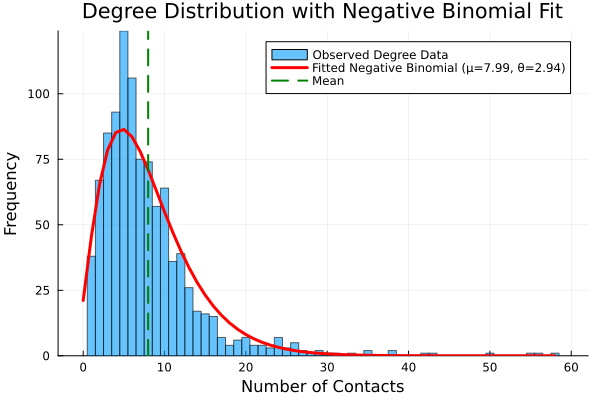

In [6]:
# Create a fitted negative binomial distribution with our parameters
nb_fit = NegativeBinomial(r̂, p̂)

# Create a histogram of our data
hist = fit(Histogram, data, nbins=maximum(data))
p = bar(hist.edges[1][1:end-1], hist.weights; 
    label="Observed Degree Data",
    xlabel="Number of Contacts", 
    ylabel="Frequency", 
    bar_width=1.0, 
    alpha=0.6, 
    legend=:topright,
    title="Degree Distribution with Negative Binomial Fit")

# Generate the probability density function of our fitted distribution
x_vals = collect(0:maximum(data))
pdf_vals = pdf.(nb_fit, x_vals) .* length(data)  # Scale to match histogram counts

# Add the PDF curve to our plot
plot!(p, x_vals, pdf_vals; 
    label="Fitted Negative Binomial (μ=$(round(fitted_μ, digits=2)), θ=$(round(fitted_θ, digits=2)))", 
    linewidth=3, 
    color=:red)

# Add expected mean vertical line
vline!([fitted_μ], label="Mean", linestyle=:dash, linewidth=2, color=:green)

# Display and save the plot
display(p)
savefig(p, "figures/degree_distribution_fit.pdf");

## Task 1: Summary

We've now completed the first task:
1. We examined the POLYMOD-like degree distribution data from `deg_dist.csv`
2. We calculated summary statistics to understand the central tendency and spread
3. We fitted a negative binomial distribution to capture the heterogeneity in contact patterns
4. We visualized the fit to assess how well the negative binomial model represents our data

The fitted parameters:
- **Mean (μ)**: Average number of contacts per person
- **Dispersion (θ)**: Determines the heterogeneity in contact counts

These parameters will now be used to:
1. Configure our epidemiological models
2. Generate synthetic contact networks with realistic properties using both the:
   - **Configuration model** (using the exact degree sequence)
   - **Proportionate mixing model** (sampling from the fitted distribution)

Next, we'll set up these network models and run epidemic simulations on them.

## Model Setup

Now let's set up the model for our investigation. As a reminder, in the initialization function, we can configure the following parameters:

### Key Parameters:

- **Network Type** (`network_type`): The structure of the network
- **Infection Seed** (`patient_zero`): Initial location of infection introduction
- **High-Risk Proportion** (`fraction_high_risk`): Fraction of population in high-risk category
- **Mean Degree** (`mean_degree`): Average connections per node

### Available Network Types:

| Type | Description |
|------|-------------|
| **Random** (`:random`) (we looked at this in Part 1) | Equal probability of connection between any nodes |
| **Small-World** (`:smallworld`) (we looked at this in Part 1) | High clustering with short average path lengths |
| **Preferential Attachment** (`:preferential`) (we looked at this in Part 1) | Scale-free networks with highly-connected hubs |
| **Configuration Model** (`:configuration`) (used here) | Specified degree distribution |
| **Proportionate Mixing** (`:proportionate`) (used here) | Specified distribution of agents with different properties |

In [7]:
include("src/initialize.jl")
# Initialization: initialize the model with the chosen parameters: network_type, patient_zero
model = initialize(; network_type=:proportionate, patient_zero=:maxdegree, r̂=r̂, p̂=p̂)

StandardABM with 1000 agents of type Person
 agents container: Dict
 space: GraphSpace with 1000 positions and 4141 edges
 scheduler: fastest
 properties: days_to_recovered, trans_prob, mean_degree, high_risk, susceptible_count, fraction_high_risk, infected_count, recovered_count, r̂, graph, dispersion, p̂, n_nodes, patient_zero, network_type

## Network Analysis

The constructed network can be analyzed using our `analyze_graph` function, which returns a comprehensive set of network metrics:

### Calculated Metrics:

| **Category**            | **Metrics**                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| **Basic properties**    | Density, Mean degree, Clustering coefficient, Assortativity                 |
| **Component analysis**  | Number of connected components, Size distribution of components              |
| **Centrality measures** | Degree centrality, Betweenness centrality, Closeness centrality, Eigenvector centrality |
| **Structural properties** | Degree distribution, Maximal cliques, Network diameter                    |

Results are organized in a dictionary with easily accessible components for further analysis and visualization.

In [8]:

include("src/analyze_graph.jl")

# Analyze the graph
graph_analysis = analyze_graph(model.graph)

# Display the analysis results
analysis_display = print_graph_analysis(graph_analysis)

# Display each component of the analysis
display("Graph Summary Metrics")
display(analysis_display.summary)

display("Centrality Measures Statistics")
display(analysis_display.centrality)

display("Component Size Summary")
display(analysis_display.component_summary)

# Save the centrality measures to a CSV file for further analysis
CSV.write("data/centrality_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["centrality"]);

# Save summary metrics to a CSV file
CSV.write("data/graph_summary_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["summary"]);

"Graph Summary Metrics"

Row,metric,value
,String,Any
1,Mean Degree,8.282
2,Density,0.00829029
3,Clustering Coefficient,0.0157541
4,Assortativity,-0.0108024
5,Diameter,Graph is not connected
6,Number of Connected Components,49
7,Max Component Length,952


"Centrality Measures Statistics"

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,degree_centrality,0.00829029,0.0,0.00700701,0.044044,0,Float64
2,betweenness_centrality,0.00214356,0.0,0.00103808,0.0282949,0,Float64
3,closeness_centrality,0.272651,0.0,0.287216,0.373015,0,Float64
4,eigenvector_centrality,0.0239294,6.18668e-14,0.0193079,0.174096,0,Float64


"Component Size Summary"

Row,component_size,count
,Int64,Int64
1,1,48
2,952,1


## Network Visualization and Analysis

We can use the results from our network analysis to create visualizations that help us understand the network structure. We'll examine:

1. **Degree distribution** - The frequency of nodes with different numbers of connections
2. **Centrality measures** - How these relate to epidemic dynamics

These visualizations provide insights into network properties that influence disease spread.

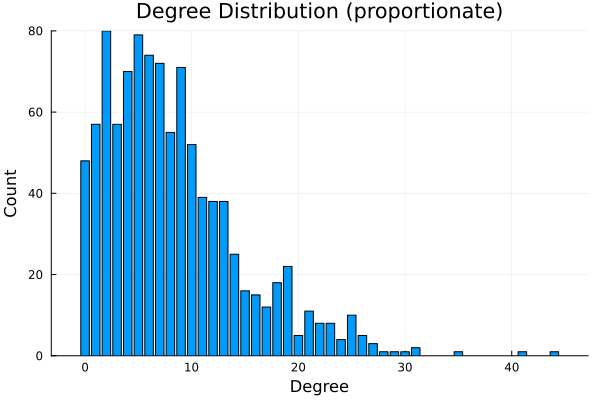

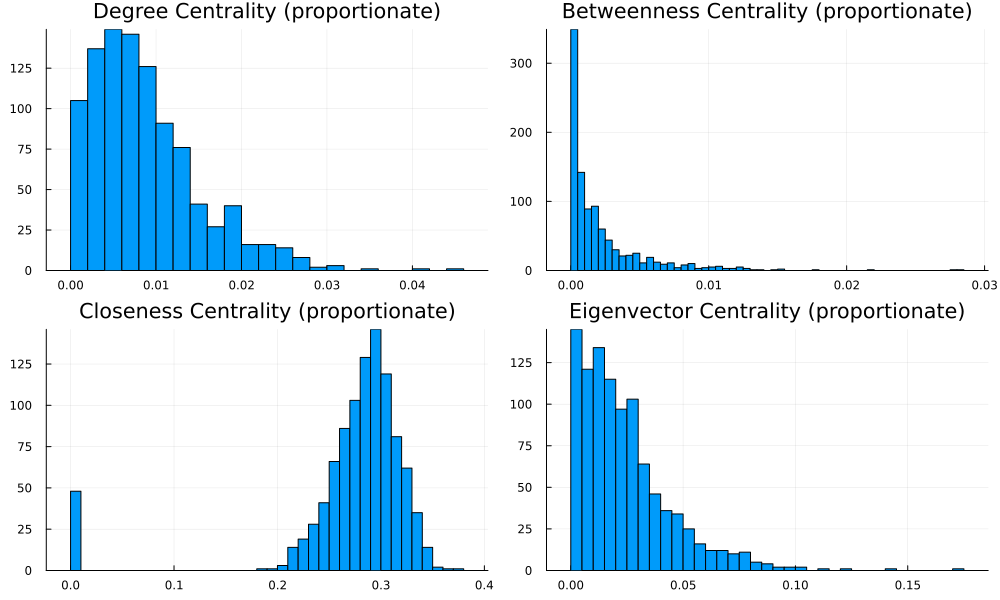

In [9]:

include("src/plotting.jl")

# Plot the degree distribution using our stored degree distribution data
plotdegdist = plot_degree_distribution(graph_analysis["degree_distribution"]; network_type=model.network_type)
display(plotdegdist)
savefig(plotdegdist, "figures/plotdegdist_$(model.network_type)_mdeg_$(model.mean_degree).pdf")

# Plot centrality distribution
p1 = histogram(graph_analysis["centrality"].degree_centrality, title="Degree Centrality ($(model.network_type))", legend=false)
p2 = histogram(graph_analysis["centrality"].betweenness_centrality, title="Betweenness Centrality ($(model.network_type))", legend=false)
p3 = histogram(graph_analysis["centrality"].closeness_centrality, title="Closeness Centrality ($(model.network_type))", legend=false)
p4 = histogram(graph_analysis["centrality"].eigenvector_centrality, title="Eigenvector Centrality ($(model.network_type))", legend=false)

centrality_plot = plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 600))
display(centrality_plot)
savefig(centrality_plot, "figures/centrality_$(model.network_type)_mdeg_$(model.mean_degree).pdf");

## Comparison with the Negative Binomial Fit

To test whether the initialized model follows the negative binomial distribution, we can compare the degree distribution of the generated network with the fitted negative binomial distribution.

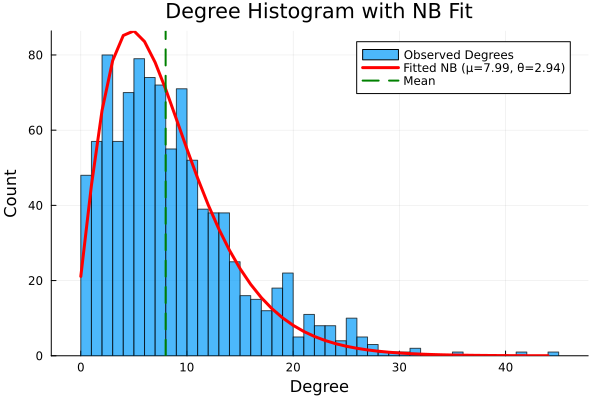

In [10]:
# Create a histogram of the degree sequence with the fitted NB distribution
degrees_from_graph = model.graph |> degree

# Create the histogram
p = histogram(degrees_from_graph, 
    nbins=maximum(degrees_from_graph), 
    xlabel="Degree", 
    ylabel="Count", 
    title="Degree Histogram with NB Fit",
    alpha=0.7,
    legend=:topright,
    label="Observed Degrees")

# Generate the probability density function of our fitted NB distribution
x_vals = collect(0:maximum(degrees_from_graph))
pdf_vals = pdf.(nb_fit, x_vals) .* length(degrees_from_graph)  # Scale to match histogram counts

# Add the PDF curve to our plot
plot!(p, x_vals, pdf_vals, 
    linewidth=3, 
    color=:red, 
    label="Fitted NB (μ=$(round(fitted_μ, digits=2)), θ=$(round(fitted_θ, digits=2)))")

# Add mean vertical line
vline!([fitted_μ], 
    label="Mean", 
    linestyle=:dash, 
    linewidth=2, 
    color=:green)

display(p)
savefig(p, "figures/degree_histogram_with_fit.pdf");

## SIR Dynamics on the Random Network

To simulate the SIR dynamics, we use the `run!` function with the following parameters:

- **Model**: Our initialized network model
- **Duration**: Number of days to simulate
- **Data collection**:
  - `adata`: Agent-level data (infection status)
  - `mdata`: Model-level data (counts of S, I, R agents)

The simulation updates each agent's status based on interactions with their neighbors, following the rules defined in our agent_step.jl file.

Results are stored in DataFrames `adf` (agent data) and `mdf` (model data) for further analysis.

In [11]:
# specify "adata" (agent data to collect) and "mdata" (model data to collect)
adata = [:status]
mdata = [:susceptible_count, :infected_count, :recovered_count]

adf, mdf = run!(model, 100; adata, mdata);

## Epidemic Trajectory Visualization

The plot below illustrates the epidemic trajectories over time:

- **Susceptible**: Decreases as the infection spreads.
- **Infected**: Rises and falls as individuals become infected and then recover.
- **Recovered**: Increases as infected individuals recover.

Saved plot filename includes:
- *Network type: (e.g., `random`, `smallworld`, etc.)*
- *Mean degree*
- *Network size:* (number of nodes)
- *Dispersion parameter*
- *Patient zero selection method*
- *Risk parameters*
- *Transmission probability*

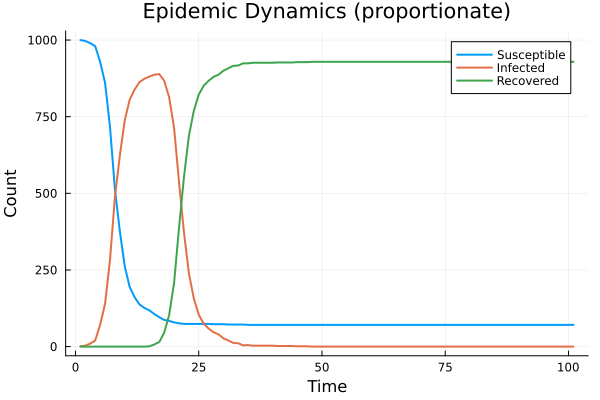

In [12]:
plotdynamics = plot_epidemic_trajectories(mdf, model.network_type)
display(plotdynamics)
savefig(plotdynamics, "figures/plotdynamics_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).pdf");

## Single Run Visualization

Let's run a single simulation and examine both:
1. The epidemic dynamics plot (showing S, I, R counts over time)
2. The degree distribution plot (showing network connectivity patterns)

The `plot_single_run` function returns both individual plots and a combined visualization, making it easy to analyze relationships between network structure and disease spread. The combined figures is saved in the `figures` directory.

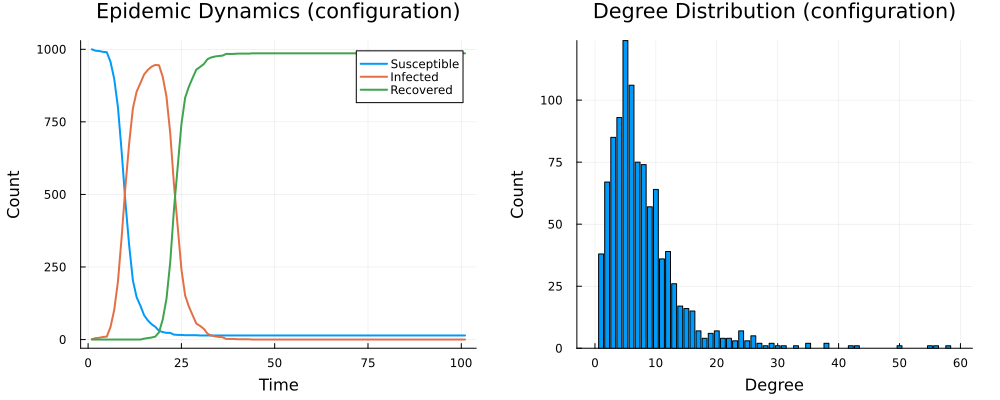

In [18]:
include("src/plotting.jl")

# Get both plots from plot_single_run
dynamics_plot, degdist_plot, combined_plot = plot_single_run(; network_type=:configuration, patient_zero=:maxdegree, r̂=r̂, p̂=p̂)

display(combined_plot)

## Multiple Run Analysis

The `run_and_plot_comparison` function generates three key epidemic metrics across multiple simulation runs (100 in this case):

1. **Epidemic Duration**: Time from first to last infection
   - *Longer durations* may indicate slower but persistent spread

2. **Maximum Infected**: Peak number of simultaneous infections
   - *Higher peaks* suggest rapid spread that could overwhelm healthcare systems

3. **Susceptible Fraction Remaining**: Population proportion that escapes infection
   - *Lower values* indicate more complete spread through the population

These metrics help quantify how network structure influences epidemic outcomes, with results automatically saved to the figures directory.

> **Note:** Outliers are not shown in the boxplots.

Running simulations for configuration network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Saving combined comparison plot to figures/combined_comparison_mdeg_4.pdf


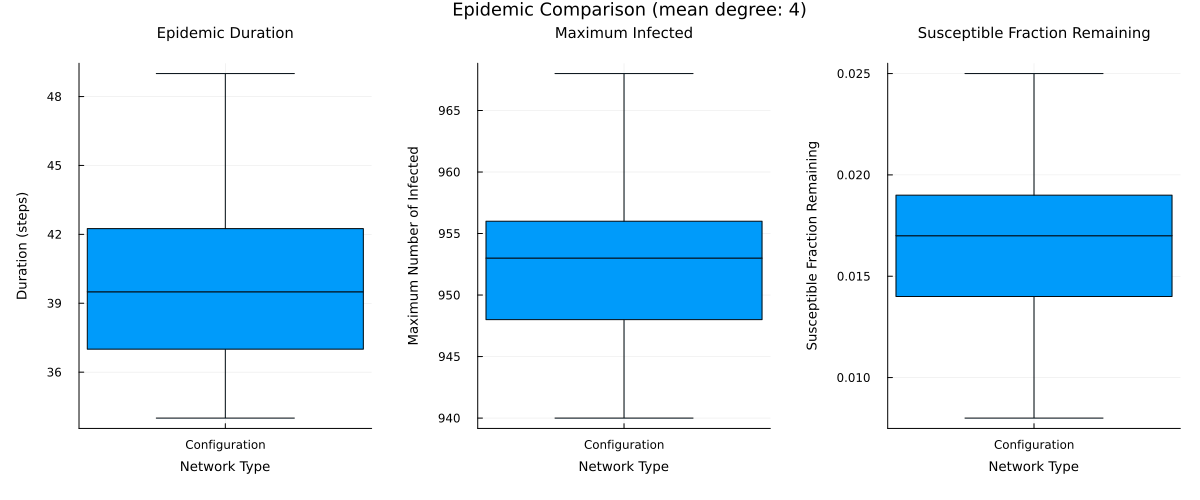

In [14]:
include("src/run_simulations.jl")
include("src/plotting.jl")
# Run simulations for multiple network types and compare their epidemic outcomes

combined_comparison = run_and_plot_comparison(
    network_types=[:configuration],
    mean_degree=4,
    patient_zero=:maxdegree,
    r̂=r̂,
    p̂=p̂,
);

# Display the combined comparison plot
display(combined_comparison)

## Comparing Different Network Types

To understand how network structure influences epidemic dynamics, we can directly compare multiple network types side by side. By passing a vector of network types (e.g., `[:random, :preferential, :smallworld]`) to the simulation and plotting functions, we generate results for each network under identical conditions.

This approach allows us to:

- **Visualize epidemic trajectories** for each network type on the same axes
- **Compare key epidemic metrics** (such as duration, peak prevalence, and final size) across network structures
- **Identify structural features** (like clustering or degree distribution) that impact disease spread

Such comparisons highlight how properties unique to each network—such as the presence of hubs in preferential attachment networks or high clustering in small-world networks—can accelerate or slow down epidemic spread. This insight is crucial for designing effective intervention strategies tailored to specific contact patterns.

Running simulations for random network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Running simulations for configuration network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Running simulations for proportionate network...
Saving simulation results to data/simulation_results...
Saving final results to output/final_results...
Saving combined comparison plot to figures/combined_comparison_mdeg_4.pdf


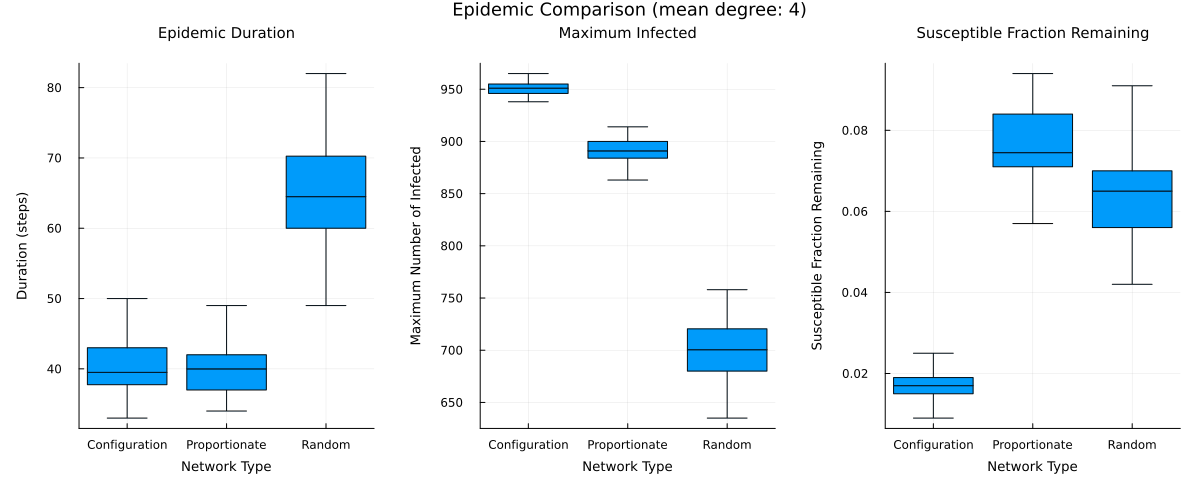

In [15]:
# Run simulations for multiple network types and compare their epidemic outcomes
combined_comparison = run_and_plot_comparison(
    network_types=[:random, :configuration, :proportionate],
    mean_degree=4,
    patient_zero=:maxdegree,
    r̂=r̂,
    p̂=p̂,
);

# Display the combined comparison plot
display(combined_comparison)

## Network Metrics Comparison

Different network topologies possess distinct structural properties that influence disease transmission dynamics. We can visualize these differences using a chart that compares key metrics across network types:

### Structural Metrics:
- **Density**: Ratio of actual connections to all possible connections
- **Clustering coefficient**: Tendency of nodes to form tightly-knit groups
- **Assortativity**: Correlation between degrees of connected nodes
  - *Positive*: Similar-degree nodes connect (homophily)
  - *Negative*: Dissimilar-degree nodes connect (heterophily)

### Centrality Metrics:
- **Degree centrality**: Number of direct connections
- **Betweenness centrality**: Frequency of node appearing on shortest paths
- **Closeness centrality**: Average distance to all other nodes
- **Eigenvector centrality**: Connection to other important nodes

Our visualization makes it easy to compare metrics across different network types at a glance.

Analyzing random network...
Analyzing configuration network...
Analyzing proportionate network...
Saving network metrics comparison plot to figures/network_metrics_comparison_random_configuration_proportionate_mdeg_4.pdf


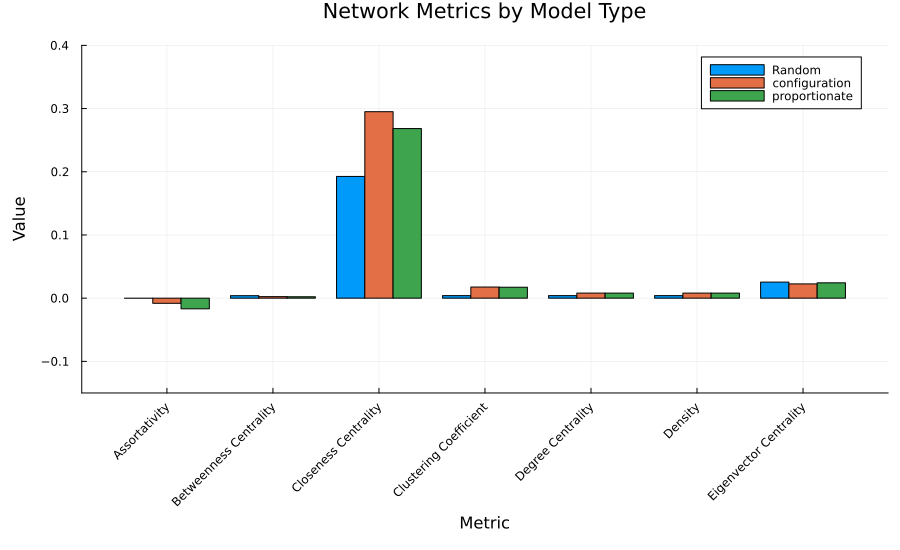

In [16]:
# Create a direct comparison of network metrics for different network types
include("src/plotting.jl")

# Use the new function to generate a comparison plot
metrics_plot = plot_network_metrics_comparison(
    network_types=[:random, :configuration, :proportionate],
    mean_degree=4,
    r̂=r̂,
    p̂=p̂,
)

# Display the plot
display(metrics_plot)

## Centrality Distribution Comparison

The boxplots below show the distribution of centrality measures across different network types:

### Centrality Measures:
- **Degree centrality**: Proportion of nodes directly connected to a node
- **Betweenness centrality**: Fraction of shortest paths passing through a node
- **Closeness centrality**: Inverse of the sum of shortest distances to all other nodes
- **Eigenvector centrality**: Measures influence based on connections to other influential nodes

The visualization highlights:
1. **Preferential attachment networks** show the highest variability in centrality measures, particularly in closeness centrality
2. **Small-world networks** have moderate closeness centrality values with less variation
3. **Random networks** generally show the lowest variability across centrality measures

These differences in centrality distributions directly impact how diseases spread through networks. Nodes with high centrality often serve as key transmission points in epidemics.

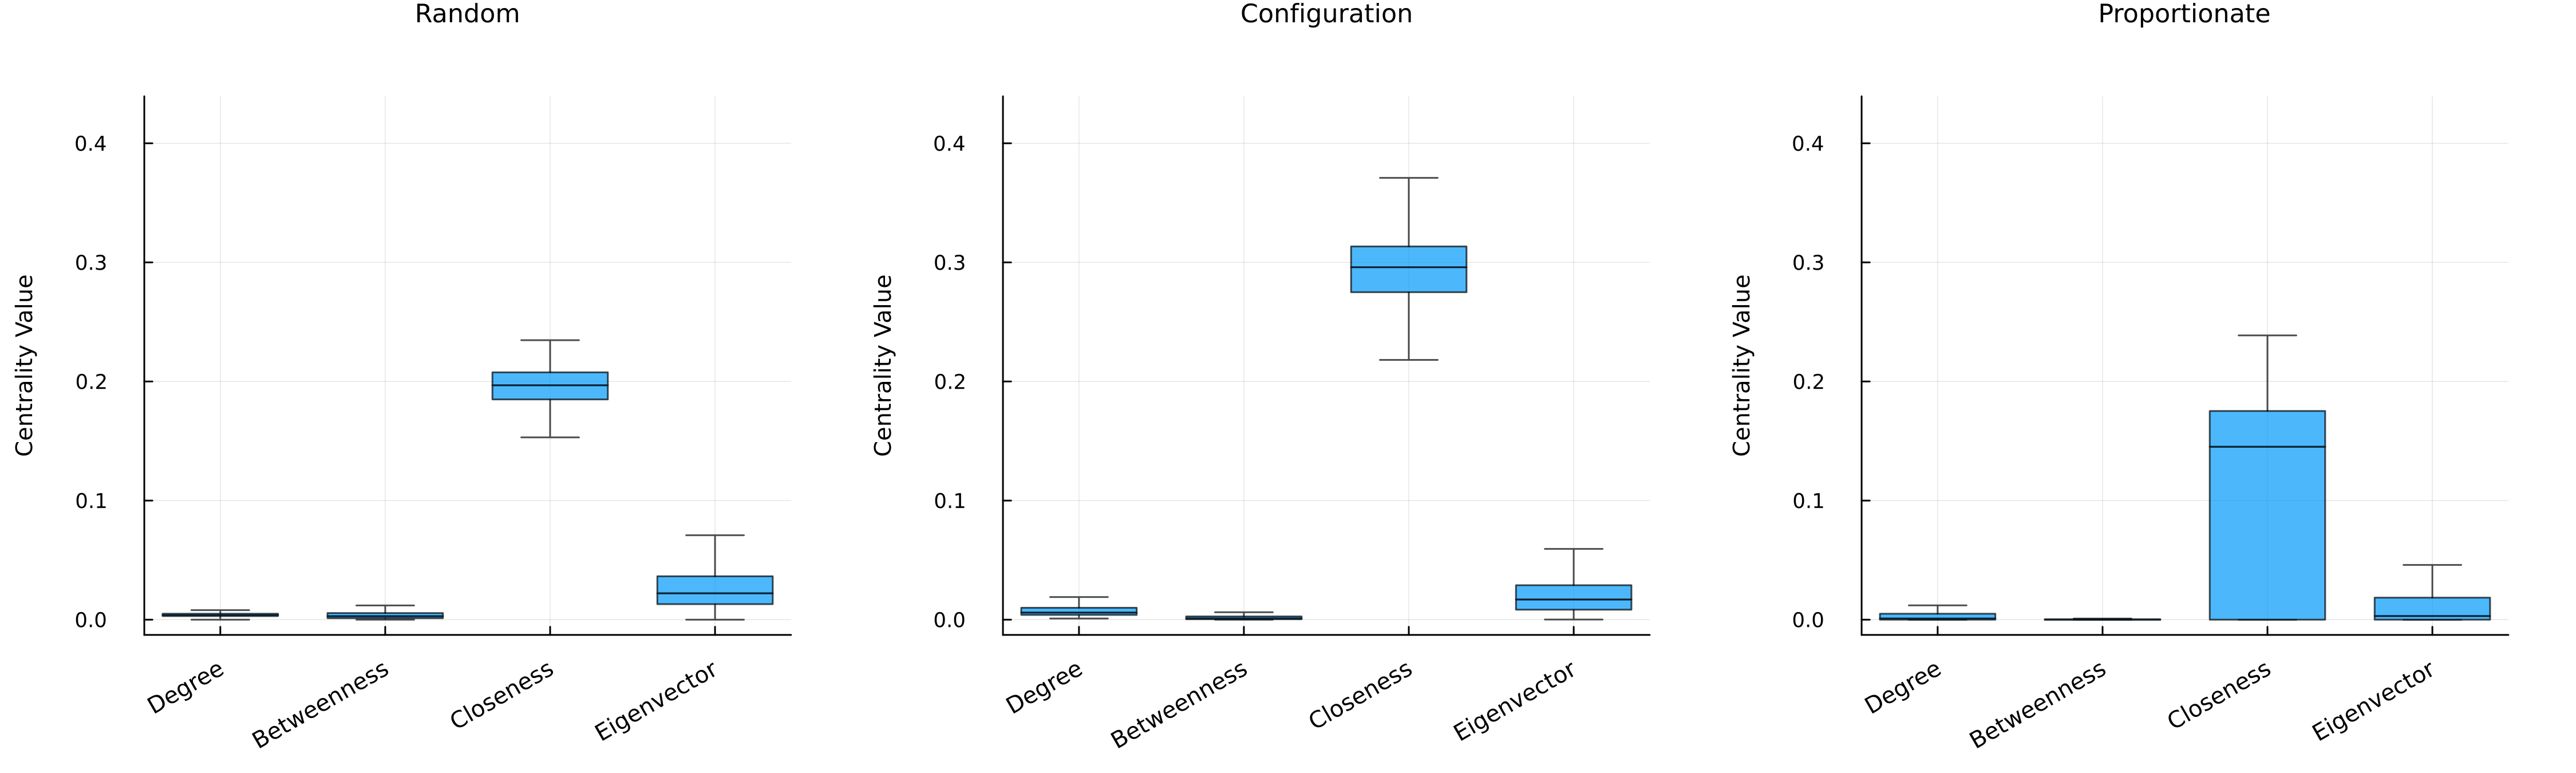

Saving combined centrality comparison plot to figures/centrality_comparison_random_configuration_proportionate_mdeg_4.pdf


In [17]:
include("src/plotting.jl")

centrality_comparison = plot_centrality_comparison(;
    network_types=[:random, :configuration, :proportionate], 
    mean_degree=4,
    link_axes=true  # Enable linked y-axes for direct comparison
)
display(centrality_comparison)